In [1]:
from matplotlib import pyplot as plt
from glob import glob 
import numpy as np

import keras
from keras import datasets
from keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import pickle

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 

onehot = OneHotEncoder()
minMax = MinMaxScaler()

#### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

* data: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

* labels: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [2]:
label2str = {0:"airplane", 1:"automobile", 2:"bird",
             3:"cat", 4:"deer", 5:"dog", 6:"frog",
             7:"horse", 8:"ship", 9:"truck"}

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

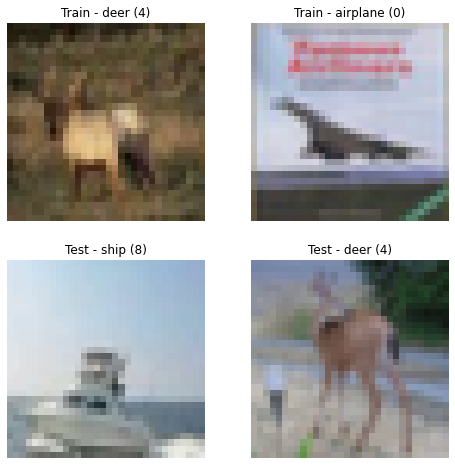

In [3]:
idx = 3
plt.figure(figsize=(8,8))

plt.subplot(221);plt.axis('off')
train_label = y_train[idx][0]
plt.title(f'Train - {label2str[train_label]} ({train_label})')
plt.imshow(x_train[idx])
           
plt.subplot(222);plt.axis('off')
test_label = y_test[idx][0]
plt.title(f'Train - {label2str[test_label]} ({test_label})')
plt.imshow(x_test[idx])

idx = 100
plt.subplot(223);plt.axis('off')
train_label = y_train[idx][0]
plt.title(f'Test - {label2str[train_label]} ({train_label})')
plt.imshow(x_train[idx])
           
plt.subplot(224);plt.axis('off')
test_label = y_test[idx][0]
plt.title(f'Test - {label2str[test_label]} ({test_label})')
plt.imshow(x_test[idx]);

In [4]:
y_train_hot = onehot.fit_transform(y_train).toarray()
y_test_hot  = onehot.transform(y_test).toarray()

In [5]:
x_train_norm = x_train/255
x_test_norm = x_test/255

# SVM

In [14]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
x_train_row = x_train_norm.reshape(len(x_train_norm), -1)

In [ ]:
svc.fit(x_train_row, y_train.ravel())

# SVM + HOG

# Row

In [66]:
model_row = keras.Sequential()
model_row.add(layers.Dense(units=512, activation='relu'))
model_row.add(layers.Dense(units=120, activation='relu'))
model_row.add(layers.Dense(units=84, activation='relu'))
model_row.add(layers.Dense(units=10, activation = 'softmax'))
model_row.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_row = x_train_norm.reshape(len(x_train_norm), -1)
test_row = x_test_norm.reshape(len(x_test_norm), -1)
model_row.fit(train_row, y_train_hot, epochs=50, batch_size=256, validation_data=(test_row, y_test_hot))

Epoch 1/50
196/196 [==============================] - 2s 9ms/step - loss: 0.3364 - accuracy: 0.2212 - val_loss: 0.2788 - val_accuracy: 0.3370
Epoch 2/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2714 - accuracy: 0.3653 - val_loss: 0.2612 - val_accuracy: 0.3857
Epoch 3/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2575 - accuracy: 0.3982 - val_loss: 0.2490 - val_accuracy: 0.4255
Epoch 4/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2482 - accuracy: 0.4218 - val_loss: 0.2454 - val_accuracy: 0.4222
Epoch 5/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2403 - accuracy: 0.4460 - val_loss: 0.2393 - val_accuracy: 0.4444
Epoch 6/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2345 - accuracy: 0.4609 - val_loss: 0.2351 - val_accuracy: 0.4613
Epoch 7/50
196/196 [==============================] - 2s 8ms/step - loss: 0.2307 - accuracy: 0.4663 - val_loss: 0.2308 - val_accuracy: 0.4714
Epoch 

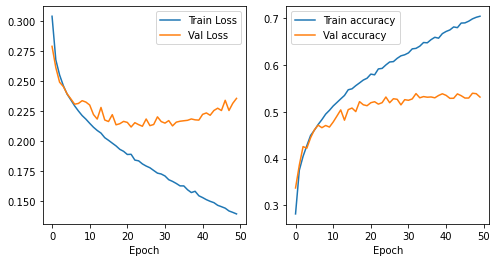

In [68]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(model_row.history.history['loss'], label="Train Loss")
plt.plot(model_row.history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(122)
plt.plot(model_row.history.history['accuracy'], label="Train accuracy")
plt.plot(model_row.history.history['val_accuracy'], label="Val accuracy")
plt.xlabel("Epoch")
plt.legend()

# As Image

In [62]:
model = keras.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=10, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train_norm, y_train_hot, epochs=50, batch_size=256, validation_data=(x_train_norm, y_train_hot))

Epoch 1/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3636 - accuracy: 0.1741 - val_loss: 0.2715 - val_accuracy: 0.3421
Epoch 2/100
196/196 [==============================] - 4s 22ms/step - loss: 0.2628 - accuracy: 0.3771 - val_loss: 0.2468 - val_accuracy: 0.4232
Epoch 3/100
196/196 [==============================] - 4s 21ms/step - loss: 0.2419 - accuracy: 0.4349 - val_loss: 0.2331 - val_accuracy: 0.4555
Epoch 4/100
196/196 [==============================] - 4s 22ms/step - loss: 0.2302 - accuracy: 0.4659 - val_loss: 0.2221 - val_accuracy: 0.4827
Epoch 5/100
196/196 [==============================] - 4s 21ms/step - loss: 0.2221 - accuracy: 0.4856 - val_loss: 0.2156 - val_accuracy: 0.5025
Epoch 6/100
196/196 [==============================] - 4s 22ms/step - loss: 0.2141 - accuracy: 0.5090 - val_loss: 0.2096 - val_accuracy: 0.5257
Epoch 7/100
196/196 [==============================] - 4s 22ms/step - loss: 0.2099 - accuracy: 0.5252 - val_loss: 0.2067 - val_accuracy:

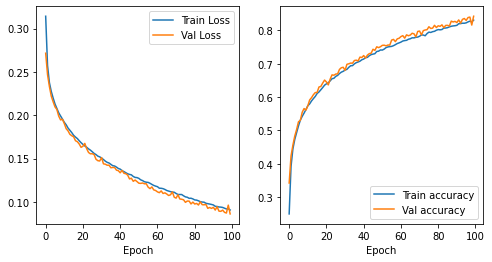

In [63]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(model.history.history['loss'], label="Train Loss")
plt.plot(model.history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(122)
plt.plot(model.history.history['accuracy'], label="Train accuracy")
plt.plot(model.history.history['val_accuracy'], label="Val accuracy")
plt.xlabel("Epoch")
plt.legend()

# Similarity 

In [121]:
sample_labels = [f"{idx} "+label2str[lab] for idx, lab in  enumerate(y_test[:,0])]
extractor     = keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
features      = extractor(x_test_norm)
distances     = pairwise_distances(features[-2])

Text(0.5, 1.0, 'Distance')

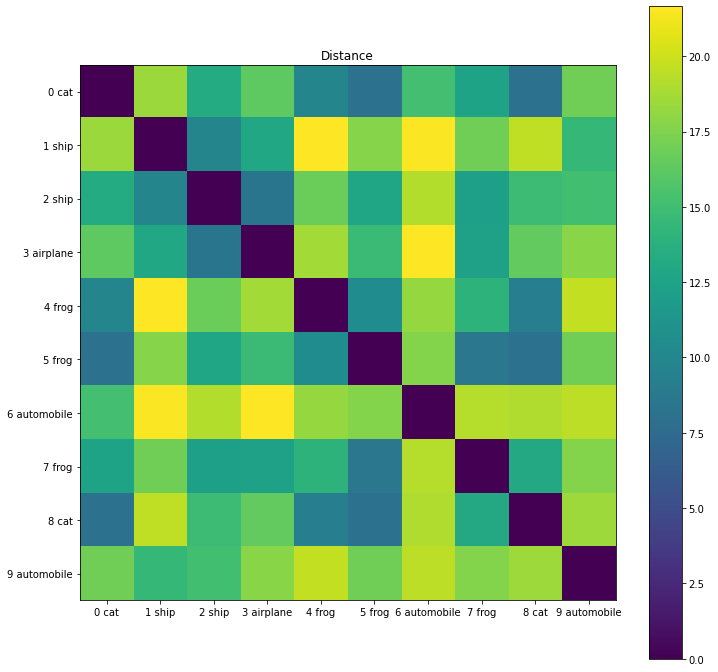

In [124]:
view_sample = 10
dist_norm = distances[:view_sample, :view_sample]
view_labels = sample_labels[:view_sample]
plt.figure(figsize=(12, 12))
plt.imshow(dist_norm)
plt.colorbar()
plt.yticks(range(view_sample), view_labels);
plt.xticks(range(view_sample), view_labels);
plt.title("Distance")

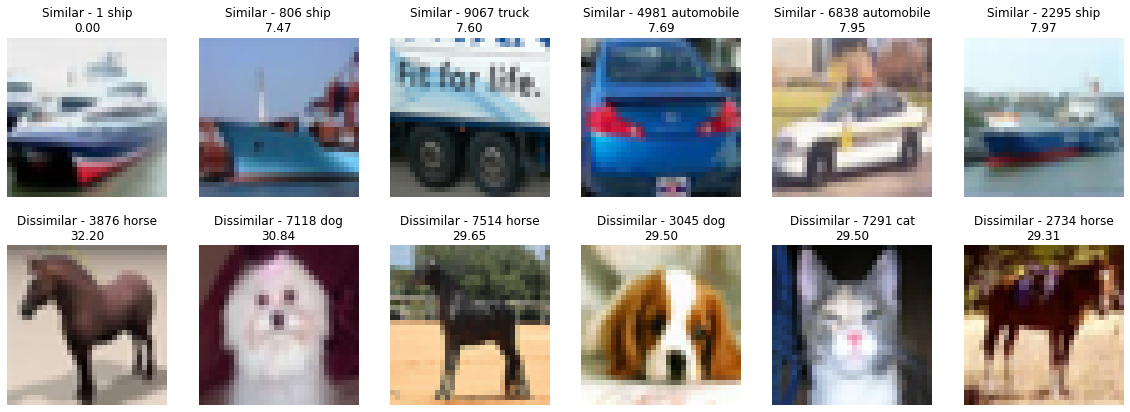

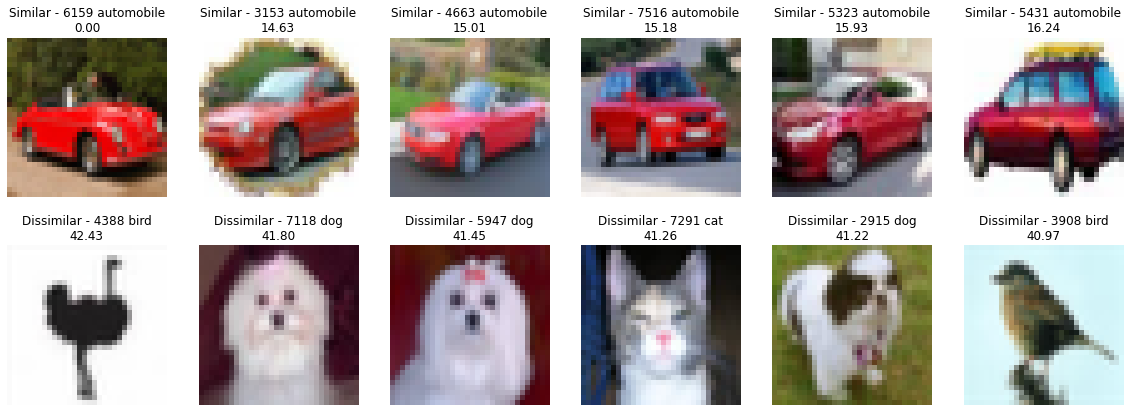

In [129]:
for id_sample in [1, 6159]:
    dist_argsort = distances[id_sample].argsort()
    similar = np.array(sample_labels)[dist_argsort]
    dist_ship = distances[id_sample][dist_argsort]

    len_data = len(x_test)
    plt.figure(figsize=(20, 7))
    for id_col in range(0, 6):
        plt.subplot(2,6, id_col+1)
        plt.title(f"Similar - {similar[id_col]}\n{dist_ship[id_col]:0.2f}")
        plt.imshow(x_test[dist_argsort[id_col]]);plt.axis('off')

    for id_col in range(0, 6):
        idx = len_data-id_col-1
        plt.subplot(2, 6, id_col+7)
        plt.title(f"Dissimilar - {similar[idx]}\n{dist_ship[idx]:0.2f}")
        plt.imshow(x_test[dist_argsort[idx]]);plt.axis('off')
